Import necessary labraries

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

Check and fill missing values (oil.csv, transactions.csv)

In [5]:
file_oil = pd.read_csv("../data/oil.csv")
file_transactions = pd.read_csv("../data/transactions.csv")

file_oil.fillna({"dcoilwtico": file_oil["dcoilwtico"].mean()}, inplace=True)#replace Nan with the average
file_transactions.fillna({
    "store_nbr": file_transactions["store_nbr"].mean(),
    "transactions": file_transactions["transactions"].mean()
}, inplace=True)                       


file_oil.to_csv("../clean_data/oil_clean.csv", index=False)
file_transactions.to_csv("../clean_data/transactions_clean.csv", index=False)


print("There's still Nan values in the file_oil." if file_oil.isnull().values.any() == True else "")
print("There's still Nan values in the file_transactions." if file_transactions.isnull().values.any() == True else "")

Generate a promotion indicator feature (based on the onpromotion column)

In [4]:
file_test = pd.read_csv("../clean_data/test_clean.csv")
file_train = pd.read_csv("../clean_data/train_clean.csv")

file_test['is_promo'] = (file_test['onpromotion'] > 0).astype(int)
file_train['is_promo'] = (file_train['onpromotion'] > 0).astype(int)

file_test.to_csv("../clean_data/test_clean.csv", index=False)
file_train.to_csv("../clean_data/train_clean.csv", index=False)

Create a cross feature between city and item family (city × item_family)

In [13]:
file_train = pd.read_csv("../clean_data/train_clean.csv")
file_stores = pd.read_csv("../data/stores.csv")
file_test = pd.read_csv("../clean_data/test_clean.csv")

merged_train = file_train.merge(file_stores, on='store_nbr', how='left')

file_train['city_family'] =  merged_train['city'] + '_' + merged_train['family']

file_train.to_csv("../clean_data/train_clean.csv", index=False)

Visualisation

/var/folders/hz/fr00vg6s2r39xwtbrmdk5pqw0000gn/T/ipykernel_61526/1572093671.py:1: DtypeWarning: Columns (9,10,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../clean_data/train_clean.csv")


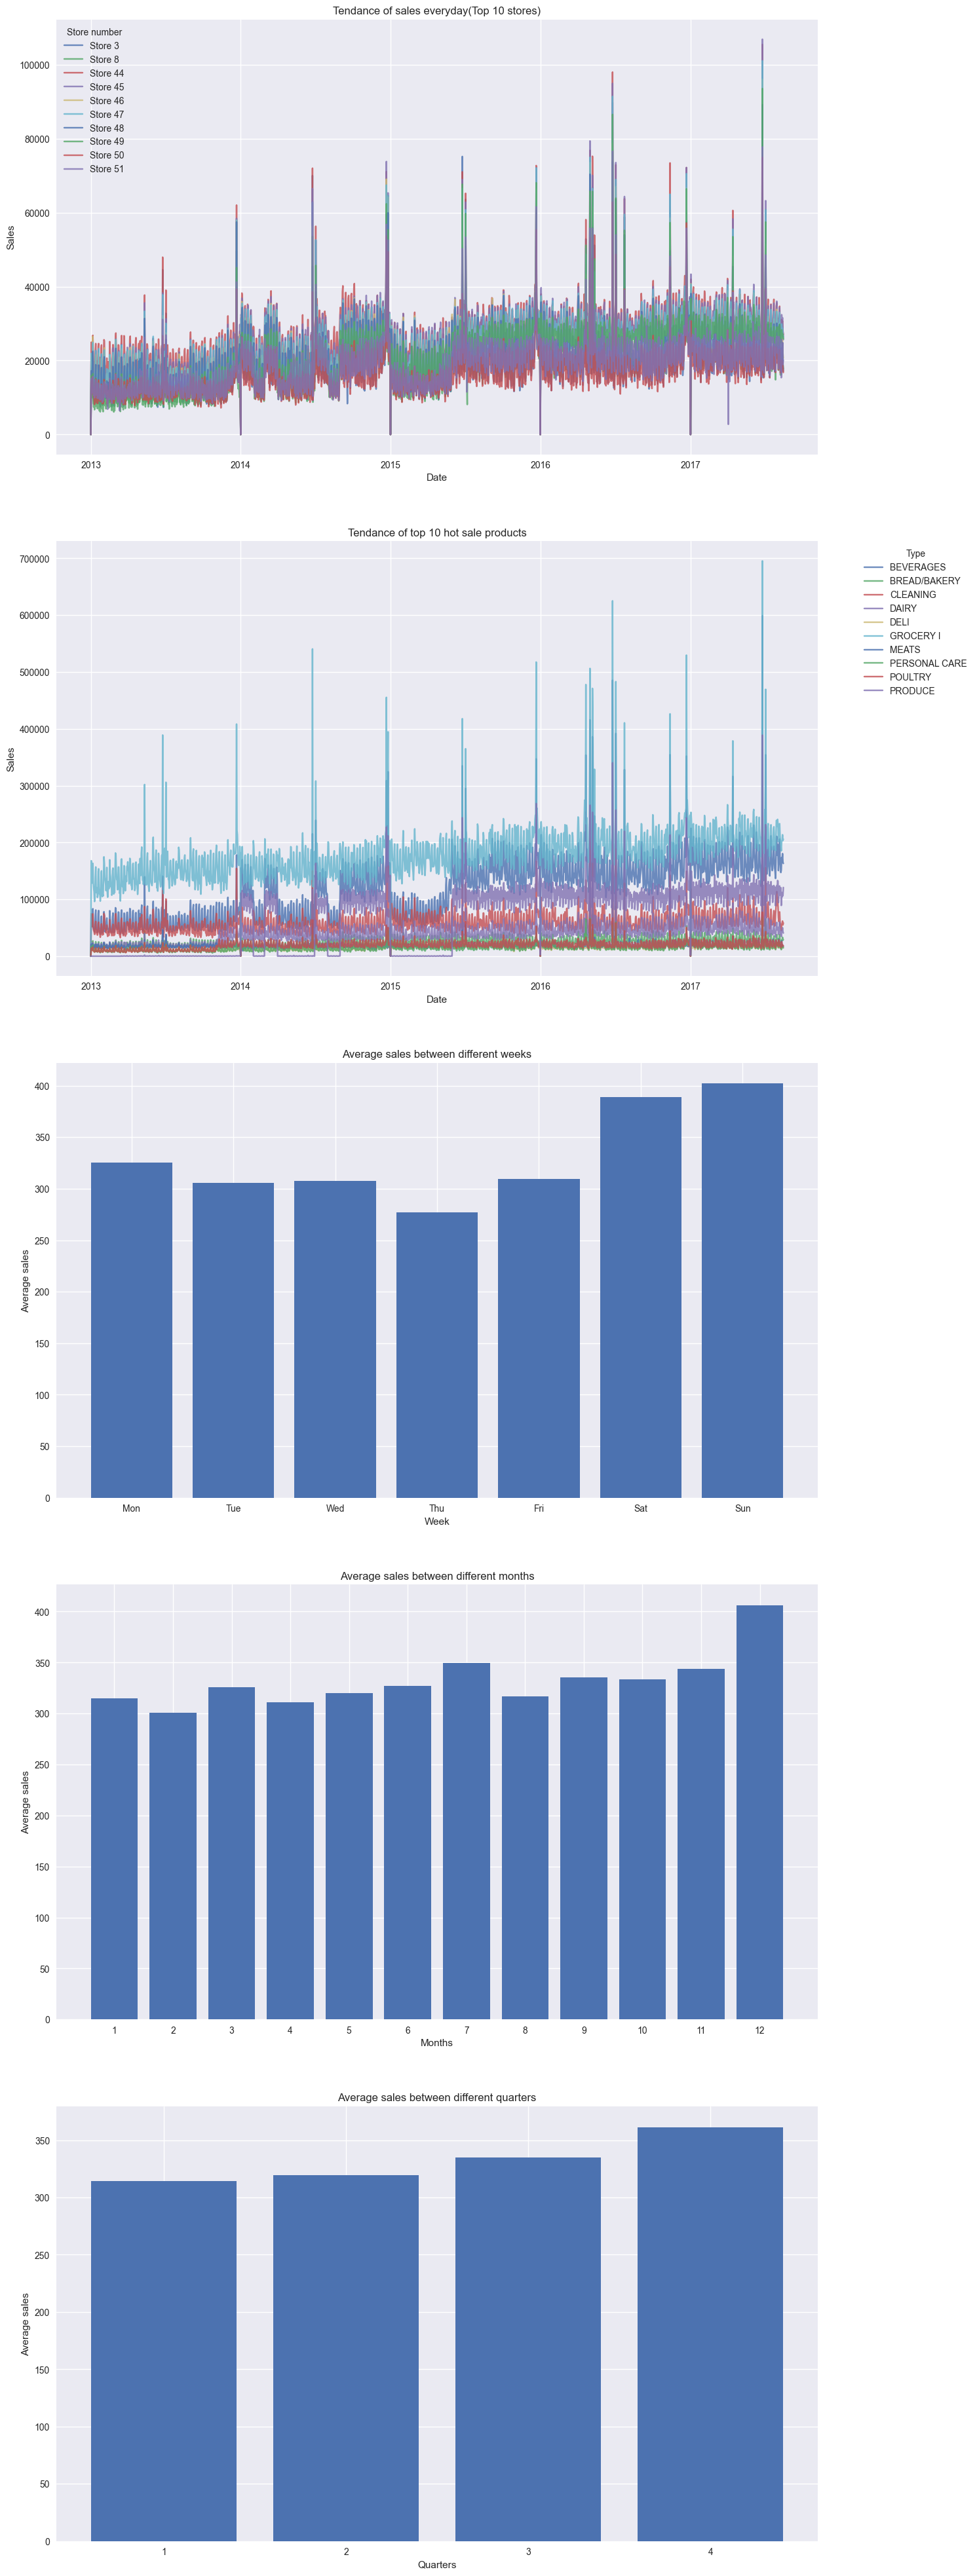

In [25]:
data = pd.read_csv("../clean_data/train_clean.csv")
data["date"] = pd.to_datetime(data["date"])

daily_store = data.groupby(["date", "store_nbr"])["sales"].sum().reset_index()

top_stores = data.groupby("store_nbr")["sales"].sum().nlargest(10).index

daily_store_top = daily_store[daily_store["store_nbr"].isin(top_stores)]

top_families = data.groupby("family")["sales"].sum().nlargest(10).index

df_top_family = data[data["family"].isin(top_families)]

daily_family = df_top_family.groupby(["date", "family"])["sales"].sum().reset_index()

data["weekday_num"] = data["date"].dt.weekday
data["weekday_name"] = data["date"].dt.day_name()

weekday_order = [0, 1, 2, 3, 4, 5, 6]

weekday_sales = data.groupby("weekday_num")["sales"].mean().reindex(weekday_order).reset_index()

weekday_map = {0:"Mon",1:"Tue",2:"Wed",3:"Thu",4:"Fri",5:"Sat",6:"Sun"}
weekday_sales["weekday"] = weekday_sales["weekday_num"].map(weekday_map)

data["month"] = data["date"].dt.month

month_sales = data.groupby("month")["sales"].mean().reset_index()

data["quarter"] = data["date"].dt.quarter

quarter_sales = data.groupby("quarter")["sales"].mean().reset_index()



fig, axs = plt.subplots(5,1,figsize=(15,50))

# plot1

for store, sub in daily_store_top.groupby("store_nbr"):
    axs[0].plot(sub["date"], sub["sales"], label=f"Store {store}", alpha=0.8)
axs[0].set_title("Tendance of sales everyday(Top 10 stores)")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Sales")
axs[0].legend(title="Store number")


# plot2

for fam, sub in daily_family.groupby("family"):
    axs[1].plot(sub["date"], sub["sales"], label=fam, alpha=0.8)

axs[1].set_title("Tendance of top 10 hot sale products")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Sales")
axs[1].legend(title="Type", bbox_to_anchor=(1.05, 1), loc="upper left")


# plot3

axs[2].bar(weekday_sales["weekday"], weekday_sales["sales"])
axs[2].set_title("Average sales between different weeks")
axs[2].set_xlabel("Week")
axs[2].set_ylabel("Average sales")


# plot4

axs[3].bar(month_sales["month"], month_sales["sales"])
axs[3].set_xticks(range(1, 13))
axs[3].set_title("Average sales between different months")
axs[3].set_xlabel("Months")
axs[3].set_ylabel("Average sales")


# plot5


axs[4].bar(quarter_sales["quarter"], quarter_sales["sales"])
axs[4].set_xticks([1, 2, 3, 4])
axs[4].set_title("Average sales between different quarters")
axs[4].set_xlabel("Quarters")
axs[4].set_ylabel("Average sales")


plt.show()
